# Subject model in tensorflow

Author: Krzystzof Rusek, AGH University of Science and Technology


In [ ]:
!pip install tensorflow_probability

In [1]:
import numpy as np
import numpy.random as rn
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')

I assume a simple user models the same as in Lucjan's simulation [Confidence Interval Simulation](https://colab.research.google.com/drive/1h-8hCWy_VWBjBQ2V5Nk5BUWN7g-0ApOp#scrollTo=6qBhGj1PBTq4):
$o_{ij} = \psi_j + \Delta_i + \epsilon_j$

Where $\psi_j \sim U(1-5)$, i.e. it is from uniform distribution. $\Delta_i \sim N(0,b)$, i.e. it is from normal distribution with mean 0 and $b$ is such that the total variance of a single PVS is constant. $\epsilon \sim N(0,a_j)$ so variance is related to PVS but not user, just for simplicity. $a_j$ is driven from Gamma distribution with some parameters. What we know is that the total standard deviation related to specific PVS should be around 0.7-0.8 (Kjell at call at May, 7, 2018). 0.75 will be the mean but distribution makes it possible to have different errors for different cases.

# Notation
https://docs.google.com/document/d/1o7nD2ztvlrhyTAB2eocb92OY2egDBjvrh-pE-zo32tQ/edit

$$U_{ij}=\psi_{j} + \Delta_i + \upsilon_i X + \phi_{j} Y$$

$$X,Y \sim N(0,1)%0$$

## Priors

$\Delta_i \sim N(0,b)$ 

$\psi_j \sim U(1-5)$ 

$\upsilon \sim Gamm(\alpha,\beta)$

$\phi \sim Gamm(\alpha,\beta)$

## Multiple solutions 

According to Jing, the ambiguous solution can be avoided by setting priors on parameters. All we need is to have $\upsilon$ and $\phi$  coming from different distributions

By learning just a MAP, we can avoid MCMC methods and use just an optimization.
For further information check the original document by Jing at the link [Setting constraints to make MLE have single optimal solution](https://docs.google.com/document/d/1QqViBmGDm3Si0hPxH4yXGxn9QjO-ZhIJkURNfSrKcK0/edit)

# MAP Estimator

$$P(\theta|d)=\frac{P(d ,\theta )}{P(d)}=\frac{P(d |\theta ) P(\theta)}{P(d)}$$

MAP estimator finds $$ \hat \theta = argmax_\theta   P(\theta|d)$$.

Going to log probs we have ($P(d)$ is marginalized over $\theta$ and can be ommited):
$$
\log P(\theta|d) = \log P(d |\theta ) + \log P(\theta) - \log P(d)
$$

This is just loglikelihood $ll=\log P(d |\theta )$ plus regularization given by log prior $\log P(\theta)$.

If we assume 

1. $\upsilon \sim Gamm(\alpha_1,\beta_1)$
1. $\phi \sim Gamm(\alpha_2,\beta_2)$

the posterior distribution is given by ([Gamma log-likelihood](https://en.wikipedia.org/wiki/Gamma_distribution#Maximum_likelihood_estimation))

$$
\log P(\theta|d) = ll + I(\alpha_1-1)\overline{\log(\upsilon_i)} -I \frac{\bar \upsilon_i}{\beta_1} + J (\alpha_2-1)\overline{\log(\phi_j)} -J \frac{\bar \phi_j}{\beta_2} + \ldots
$$

We know that maximum of $ll$ is not unique under transformations..., however, log prior does not have such symmetry.
In other words, the internal degree of freedom in log likelihood is fixed by prior assumptions about parameters that serve as constraints.

In [330]:
nPVS = 160 # number of PVSs
nSub = 10*24 # number of Subjects

std = 0.75 # it is standard deviation for typical PVS
alpha = 30.0 # it is parameter of the gamma distribution from which the variances are generated 
b = 0.3 # standard deviation for delta distribution

psi = rn.uniform(1,5, size=(nPVS,1)) # MOSs generation
fi = rn.gamma(alpha, np.sqrt(0.5*(std**2 - b**2))/alpha, size=(nPVS,1)) # std per PVS with delta
upsilon = rn.gamma(alpha, np.sqrt(0.5*(std**2 - b**2))/alpha, size=(1,nSub)) # std per PVS with delta
Delta = rn.normal(0, b, size=(1,nSub)) # Delta generation 


# Notes

1. Prior improve estimation
1. Estimating continous model from quantized distribution is the most robus, $\Delta$ is biased
1. Hand coded log joint probability, `tfp.edward2.make_log_joint` alows for infering continous score
1. Full Bayess is just one step ahead: MCMC, or StochasticGradientLangevinDynamics
1. $\infty$ in loss, but converges !


## TODO

1. [ ] Test various optimizers
1. [ ] Fisher information matrix as Hessian approximation? GradientDescent works quite well
1. [ ] Proper multinomial distribution for test results (hancoded mapping for continous score)
1. [x] ~~Hack Optimizer for `tf.float64`~~
1. [x] ~~Move this to github~~

# Generative model

The code uses Edwart2 probabilistic programming language from [tensorflow_probability](https://github.com/tensorflow/probability) package

In [331]:
g = tf.Graph()
with g.as_default():
    tf_delta = tf.Variable(Delta.astype(np.float32))
    tf_psi = tf.Variable(psi.astype(np.float32))

    loc = tf_delta + tf_psi
    
    #make sure std is always positive
    
    tf_upsilon_sqr = tf.Variable(np.sqrt(upsilon).astype(np.float32))
    tf_upsilon = tf_upsilon_sqr**2
    
    tf_fi_sqr = tf.Variable(np.sqrt(fi).astype(np.float32))
    tf_fi = tf_fi_sqr**2
    
    scale = tf.sqrt(tf_upsilon**2 + tf_fi**2)
    #o = tfp.edward2.Normal(loc=loc-np.float64(0.5),scale=scale)
    #o = tfp.edward2.QuantizedDistribution(o.distribution, low=1.0, high=5.0)
    
    discretized_normal = tfp.distributions.QuantizedDistribution(
        distribution=tfp.distributions.TransformedDistribution(
            distribution=tfp.distributions.Normal(loc=loc, scale=scale),
            bijector=tfp.bijectors.AffineScalar(shift=-0.5)),
        low=1.0,
        high=5.0)
    


with tf.Session(graph=g) as sess:
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    o_val, = sess.run([discretized_normal.sample()])
    print(o_val)

[[2. 2. 2. ... 2. 2. 3.]
 [3. 4. 3. ... 3. 4. 4.]
 [1. 2. 2. ... 2. 1. 1.]
 ...
 [4. 4. 4. ... 5. 5. 4.]
 [4. 5. 4. ... 3. 3. 5.]
 [4. 2. 4. ... 5. 3. 4.]]


In [304]:
import numpy.random as rn
import numpy as np
import scipy.stats as stat

oij = [] # generating opinions (continoues)
for i in range (0, nPVS):                              
    new = []                  
    for j in range (0, nSub):  
        o = psi[i,0] + Delta[0,j] + rn.normal(0, np.sqrt(fi[i,0]**2 + upsilon[0,j]**2 ))
        #o = np.ceil(o)
        #o = np.round(o)
        o = np.ceil(o-0.5)

        if o < 1:
            o =1
        if o > 5:
            o=5
        new.append(o)      
    oij.append(new) 

mos = [] # calculating some statistics
sd = []
for scores in oij:
    mos.append(np.mean(scores))
    sd.append(np.std(scores))
o_val = np.asarray(oij)

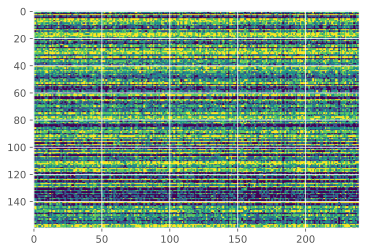

In [332]:
plt.imshow(o_val/5)

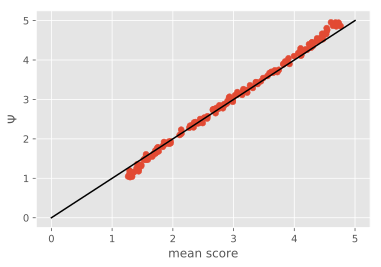

In [333]:
plt.scatter(np.mean(o_val,axis=1),psi)
plt.plot([0,5],[0,5],'k')
plt.xlabel('mean score')
plt.ylabel(r'$\Psi$');

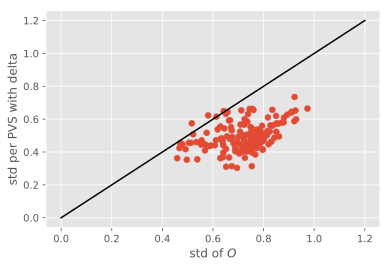

In [334]:
plt.scatter(np.std(o_val,axis=1),fi)
plt.plot([0,1.2],[0,1.2],'k')
plt.xlabel('std of $O$')
plt.ylabel(r'std per PVS with delta');

Let us now use the generative code for inference with  $\Delta$,  $\psi$ ,$\upsilon$ and $\phi$ as variables


* Distribution of $O_{ij}$ is quantized normal implemeted using  ```tfp.edward2```
* MLE is obtained by minimizing negative log_prob.
* Initial condition from moments estimators
* MAP is just MLE with prior loglik as regularization 

In [19]:
o_val

array([[1., 1., 2., ..., 2., 1., 1.],
       [2., 2., 2., ..., 3., 2., 3.],
       [4., 4., 4., ..., 4., 3., 5.],
       ...,
       [2., 1., 1., ..., 3., 2., 3.],
       [2., 3., 2., ..., 2., 3., 2.],
       [5., 2., 2., ..., 3., 1., 4.]], dtype=float32)

In [335]:
g = tf.Graph()
with g.as_default():
    
    #Plausible initial conditions
    psi_in = rn.uniform(1,5, size=(nPVS,1)) # MOSs generation
    fi_in = rn.gamma(alpha, np.sqrt(0.5*(std**2 - b**2))/alpha, size=(nPVS,1)) # std per PVS with delta
    upsilon_in = rn.gamma(alpha, np.sqrt(0.5*(std**2 - b**2))/alpha, size=(1,nSub)) # std per PVS with delta
    Delta_in = rn.normal(0, b, size=(1,nSub)) # Delta generation 

    # Copy-Paste
    # TODO move this to function
    
    tf_delta = tf.Variable(Delta_in.astype(np.float64))
    tf_psi = tf.Variable(psi_in.astype(np.float64))

    loc = tf_delta + tf_psi
    
    #make sure std is always positive
    
    tf_upsilon_sqr = tf.Variable(np.sqrt(upsilon_in).astype(np.float64))
    tf_upsilon = tf_upsilon_sqr**2
    
    tf_fi_sqr = tf.Variable(np.sqrt(fi_in).astype(np.float64))
    tf_fi = tf_fi_sqr**2
    
    scale = tf.sqrt(tf_upsilon**2 + tf_fi**2)
    
    
    continous = tfp.distributions.Normal(loc=loc,scale=scale)

    #o = tfp.distributions.QuantizedDistribution(continous,low=np.float64(1.0), high=np.float64(5.0) )

#     o = tfp.distributions.QuantizedDistribution(
#         distribution=tfp.distributions.TransformedDistribution(
#             distribution=tfp.distributions.Normal(loc=loc, scale=scale),
#             bijector=tfp.bijectors.AffineScalar(shift=np.float64(-0.5))),
#         low=np.float64(1.0),
#         high=np.float64(5.0))

    
    o = continous
    loglik = tf.reduce_mean(o.log_prob(o_val.astype(np.float64)))
    
    delta_prior = tfp.distributions.Normal(loc=np.float64(0.0),scale=np.float64(0.3) )
    psi_prior = tfp.distributions.Uniform(low=np.float64(1.0),
                                    high=np.float64(5.0) )
    #the same for fi
    upsilon_prior = tfp.distributions.Gamma(
        concentration=np.float64(alpha),
        rate=np.float64(alpha/np.sqrt(0.5*(std**2 - b**2))))

    upsilon_prior = tfp.distributions.Gamma(
        concentration=np.float64(alpha),
        rate=np.float64(alpha/np.sqrt(0.5*(std**2 - b**2))))

    
    prior_log_prob = tf.reduce_sum(delta_prior.log_prob(tf_delta)) + \
        tf.reduce_sum(psi_prior.log_prob(tf_psi)) + \
        tf.reduce_sum(upsilon_prior.log_prob(tf_upsilon)) + \
        tf.reduce_sum(upsilon_prior.copy().log_prob(tf_fi)) # not an erro

    loss = -loglik - prior_log_prob /np.float64(nPVS*nSub)
    #loss = -loglik 
    

    gs=tf.contrib.training.get_or_create_eval_step()
#    lr = tf.train.exponential_decay(0.1,gs,decay_steps=100,decay_rate=0.9999)
#    train_op = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(-loss, global_step=gs)
    
    # to jest bardzo dobre
    train_op = tf.train.RMSPropOptimizer(learning_rate=0.02, epsilon=0.01).minimize(loss)

with tf.Session(graph=g) as sess:
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    for i in range(10000):
        _,np_loss,np_reg = sess.run([train_op,loss,prior_log_prob])
        if i % 500 ==0:
            print(i,np_loss,np_reg)
    (delta_hat, 
     psi_hat, 
     upsilon_hat, 
     fi_hat, 
     loss_val) = sess.run([tf_delta,tf_psi,tf_upsilon,tf_fi,loss])


0 3.421666252693043 114.26953967372913
500 1.4959718088566836 -1624.3579582761865
1000 1.315481509943822 -895.7216370127759
1500 1.1953728473284198 -407.796218730277
2000 1.1134293657131416 -108.11015934327844
2500 1.0648359210667124 44.56491715339855
3000 1.0388389295654585 124.78494188014547
3500 1.0241548133684164 174.58407634990937
4000 1.0127757431639444 200.88958852433274
4500 1.0084642670912454 196.62154710391152
5000 1.0081451940536554 192.41919392980606
5500 1.0081332405166499 191.64919940412366
6000 1.0081315546863343 191.52939874901637
6500 1.0081305376741831 191.5236416498211
7000 1.0081296196278744 191.5435011871513
7500 1.0081287416158606 191.57076852154364
8000 1.0081278948174879 191.60031033737107
8500 1.008127077011946 191.63025530785364
9000 1.0081262870180892 191.65982694825686
9500 1.0081255238564428 191.68869314695587


Text(0,0.5,'Recovered upsilon')

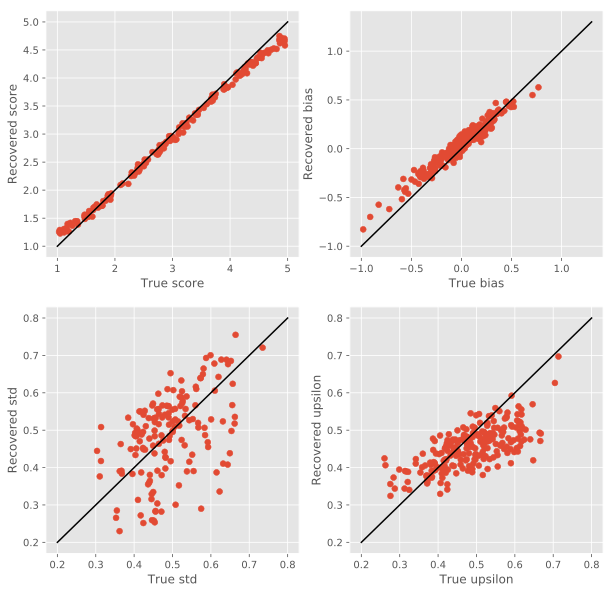

In [336]:
fig,ax = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(10,10)

ax[0,0].scatter(psi,psi_hat)
ax[0,0].plot([1,5],[1,5],'k')
ax[0,0].set_xlabel('True score')
ax[0,0].set_ylabel('Recovered score')

ax[0,1].scatter(Delta,delta_hat)
ax[0,1].plot([-1,1.3],[-1,1.3],'k')
ax[0,1].set_xlabel('True bias')
ax[0,1].set_ylabel('Recovered bias')

ax[1,0].scatter(fi,fi_hat)
ax[1,0].plot([0.2,0.8],[0.2,0.8],'k')
ax[1,0].set_xlabel('True std')
ax[1,0].set_ylabel('Recovered std')

ax[1,1].scatter(upsilon,upsilon_hat)
ax[1,1].plot([0.2,0.8],[0.2,0.8],'k')
ax[1,1].set_xlabel('True upsilon')
ax[1,1].set_ylabel('Recovered upsilon')



# Edward2 log_joint

In [ ]:
def subject_model():
    delta_prior = tfp.edward2.Normal(loc=np.zeros((1,nSub), dtype=np.float32) ,scale=0.3,name="delta")
    psi_prior = tfp.edward2.Uniform(low=np.ones((nPVS,1),dtype=np.float32), high=5.0,name="psi")
    #the same for fi
    upsilon_prior = tfp.edward2.Gamma(
        concentration=np.float32(alpha)*np.ones((1,nSub),dtype=np.float32),
        rate=np.float32(alpha/np.sqrt(0.5*(std**2 - b**2))),name="upsilon")
    fi_prior = tfp.edward2.Gamma(
        concentration=np.float32(alpha)*np.ones((nPVS,1),dtype=np.float32),
        rate=np.float32(alpha/np.sqrt(0.5*(std**2 - b**2))),name="fi")
    
    
    n = tfp.edward2.Normal(loc=delta_prior + psi_prior,
                         scale=tf.sqrt(upsilon_prior**2 + fi_prior**2), name="n")
    #o = tfp.edward2.QuantizedDistribution(n.distribution, low=1.0, high=5.0, name="o")
    return o

def subject_model2():
    delta = tfp.edward2.Normal(loc=0.0,scale=0.3, 
                               sample_shape=(1,nSub),
                              name="delta")

    psi = tfp.edward2.Uniform(low=1.0, high=5.0, 
                              sample_shape=(nPVS,1),
                             name="psi")

    upsilon = tfp.edward2.Gamma(
        concentration=float(alpha),
        rate=float(alpha/np.sqrt(0.5*(std**2 - b**2))),
        sample_shape=(1,nSub),
        name="upsilon")
    
    fi = tfp.edward2.Gamma(
        concentration=float(alpha),
        rate=float(alpha/np.sqrt(0.5*(std**2 - b**2))),
        sample_shape=(nPVS,1),name="fi")
    
    
    o = tfp.edward2.Normal(loc=delta + psi,
                         scale=tf.sqrt(upsilon**2 + fi**2), name="o")
    
    #o2 = tfp.edward2.QuantizedDistribution(o.distribution, low=1.0, high=5.0,name='o2')
    return o#2


g = tf.Graph()
with g.as_default():

    psi_in = rn.uniform(1,5, size=(nPVS,1)) # MOSs generation
    fi_in = rn.gamma(alpha, np.sqrt(0.5*(std**2 - b**2))/alpha, size=(nPVS,1)) # std per PVS with delta
    upsilon_in = rn.gamma(alpha, np.sqrt(0.5*(std**2 - b**2))/alpha, size=(1,nSub)) # std per PVS with delta
    Delta_in = rn.normal(0, b, size=(1,nSub)) # Delta generation 

   
    tf_delta = tf.Variable(Delta_in.astype(np.float32))
    tf_psi = tf.Variable(psi_in.astype(np.float32))
    
    tf_upsilon_sqr = tf.Variable(np.sqrt(upsilon_in).astype(np.float32))
    tf_upsilon = tf_upsilon_sqr**2
    
    tf_fi_sqr = tf.Variable(np.sqrt(fi_in).astype(np.float32))
    tf_fi = tf_fi_sqr**2

    #oo=subject_model2()
    log_joint = tfp.edward2.make_log_joint_fn(subject_model2)
    
    opreq = tf.get_variable('opreq',shape=o_val.shape,dtype=o_val.dtype)
    
    loss = -log_joint(delta=tf_delta,
                     psi = tf_psi,
                     upsilon = tf_upsilon,
                     fi=tf_fi,
                     #o=opreq,
                     o=o_val)
    #train_op = tf.train.RMSPropOptimizer(learning_rate=0.0008).minimize(loss)
    #train_op = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss)
    train_op = tf.train.AdagradOptimizer(learning_rate=0.01).minimize(loss)
        
with tf.Session(graph=g) as sess:
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    for i in range(100000):
        _,np_loss = sess.run([train_op,loss])
        if i % 1000 ==0:
            print(i,np_loss)
    (delta_hat, 
     psi_hat, 
     upsilon_hat, 
     fi_hat, 
     loss_val) = sess.run([tf_delta,tf_psi,tf_upsilon,tf_fi,loss])


In [ ]:
from tensorflow_probability import edward2 as ed

def model():
      w = ed.Normal(loc=0., scale=1., sample_shape=, name="w")
      y = ed.Normal(loc=tf.tensordot(X, w, [[1], [0]]), scale=0.1, name="y")
      return y

g = tf.Graph()
with g.as_default():
    log_joint = ed.make_log_joint_fn(model)

    X = tf.random_normal([3, 2])
    w_value = tf.random_normal([2])
    y_value = tf.random_normal([3])
    output = log_joint(X, w=w_value, y=y_value)

with tf.Session(graph=g) as sess:
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    print(output.eval())

-170.40956
